# LLaVA-Med 1.5 OpenVINO demo

NOTE: This OpenVINO model is unvalidated. Results are provisional and may contain errors. Use this demo to explore AI PC and OpenVINO optimizations

Source model: [microsoft/LLaVA-Med](https://github.com/microsoft/LLaVA-Med). For research purposes only.


In [2]:
import json
import os
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import torch
from PIL import Image
from transformers import logging

from llava.constants import DEFAULT_IMAGE_TOKEN, IMAGE_TOKEN_INDEX
from llava.conversation import conv_templates
from llava.mm_utils import get_model_name_from_path, process_images, tokenizer_image_token
from llava.model.builder import load_pretrained_model

logging.set_verbosity_error()
image_folder = "data\\qa50_images"

time: 4.22 s (started: 2025-02-25 07:34:24 -07:00)


## Load Model and Data

In [3]:
model_path = "llava-med-imf16-llmint4"
# model_path = "llava-med-imint8-llmint4"
model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path, model_base=None, model_name=model_name, device="gpu", openvino=True, image_device="npu"
)

questions = []
with open("data/eval/llava_med_eval_qa50_qa.jsonl") as f:
    for line in f:
        questions.append(json.loads(line))

time: 27.4 s (started: 2025-02-25 07:34:28 -07:00)


## Functions

In [4]:
def prepare_inputs(question):
    conv_mode = "vicuna_v1"  # default
    qs = question["text"].replace(DEFAULT_IMAGE_TOKEN, "").strip()
    qs = DEFAULT_IMAGE_TOKEN + "\n" + qs  # model.config.mm_use_im_start_end is False

    conv = conv_templates[conv_mode].copy()
    conv.append_message(conv.roles[0], qs)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()
    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0)

    image = Image.open(os.path.join(image_folder, question["image"]))
    image_tensor = process_images([image], image_processor, model.config)[0]
    return input_ids, image_tensor


def run_inference(model, question):
    input_ids, image_tensor = prepare_inputs(question)
    image = Image.open(os.path.join(image_folder, question["image"]))
    display(image)
    print(f"Question: {question['text'].replace(DEFAULT_IMAGE_TOKEN,'')}")
    ov_output_ids = model.generate(
        input_ids,
        images=image_tensor.unsqueeze(0).half(),
        do_sample=False,
        # no_repeat_ngram_size=3,
        max_new_tokens=1024,
        use_cache=True,
    )

    input_length = input_ids.shape[-1]
    ov_output_ids = ov_output_ids[:, input_length:]
    answer = tokenizer.batch_decode(ov_output_ids, skip_special_tokens=True)[0].strip()
    print(f"Answer: {answer}")

time: 0 ns (started: 2025-02-25 07:34:56 -07:00)


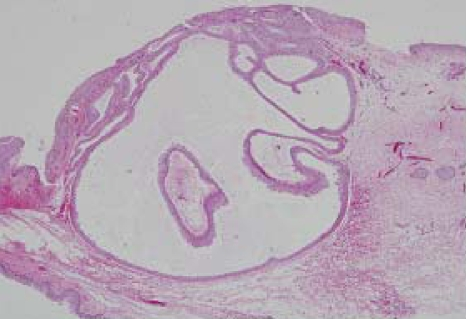

Question: What is the organ in the image?

Answer: The organ in the image is the gallbladder, which is a small, pear-shaped organ located beneath the liver in the upper right abdomen.
time: 4.42 s (started: 2025-02-25 07:34:56 -07:00)


In [5]:
# suggested indices are indices where model output is similar to source model output
# it may still be incorrect!
# int8 image model: 2, 13, 14, 16, 17 (shorter) and  4, 5, 8 (longer)
# f32 image model : 0, 2, 7, 9, 13, 14, 15, 16, 17, 18, 19 (shorter) and 3,5,6,8 (longer)

run_inference(model, questions[0])

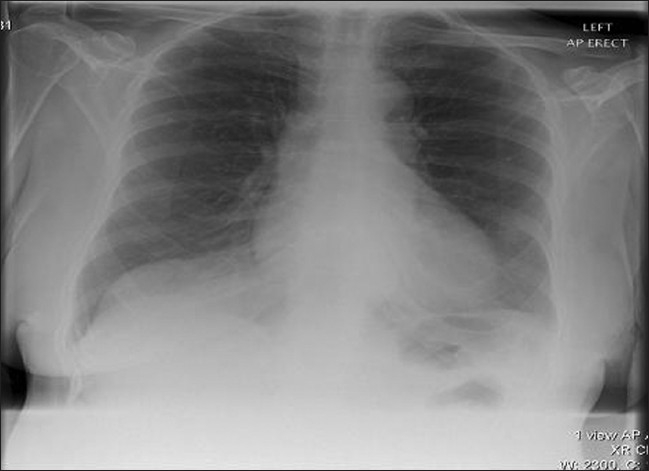

Question: Are there any signs of lymph node involvement?

Answer: According to the chest X-ray, there are no signs of lymph node involvement.
time: 3.36 s (started: 2025-02-25 07:35:00 -07:00)


In [6]:
run_inference(model, questions[13])